In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import calinski_harabasz_score
import pandas as pd

from models.CAE import CAE
from models.VCAE import VCAE
from generate import sin_cos, arma, wind
from train import train
from utils import latent_space, choose_bottleneck

torch.manual_seed(4444)
np.random.seed(4444)

# Create Dataset

In [2]:
n_train = 100
n_valid = 100
n_test = 100
n = n_train+n_valid+n_test

length = 64 # each observation is a vector of size (1,length)

## Generate documents

In [3]:
X = sin_cos(n, length)
#X = arma(n, length)
#X = wind(num_elems=length)

X = torch.from_numpy(X)
print("shape of X:", X.shape)

X_train, X_valid, X_test = X[:n_train], X[n_train:n_train+n_valid], X[n_train+n_valid:]

shape of X: torch.Size([300, 1, 64])


# Model

In [4]:
M = 4 # number of filters per conv
Lf = 3 # size of the filters
bottleneck_nn = 32
model = VCAE(length=length, Lf=Lf, M=M, bottleneck_nn=bottleneck_nn)

## Train

In [5]:
batch_size = 32
train_losses, valid_losses = train(model, X_train, X_valid, iters=3000, early_stopping_rounds=30, batch_size=32)

EPOCH 10 train loss: 0.9276818335056305, valid loss: 0.9410655945539474
epochs without improvement: 0

EPOCH 20 train loss: 0.8277975767850876, valid loss: 0.8189921230077744
epochs without improvement: 0

EPOCH 30 train loss: 0.604776568710804, valid loss: 0.6137078627943993
epochs without improvement: 0

EPOCH 40 train loss: 0.4152001850306988, valid loss: 0.4299667701125145
epochs without improvement: 0

EPOCH 50 train loss: 0.32122902572155, valid loss: 0.32204095646739006
epochs without improvement: 0

EPOCH 60 train loss: 0.25944171845912933, valid loss: 0.24962046183645725
epochs without improvement: 0

EPOCH 70 train loss: 0.2156576495617628, valid loss: 0.23041978292167187
epochs without improvement: 4

EPOCH 80 train loss: 0.1902198027819395, valid loss: 0.18788975290954113
epochs without improvement: 0

EPOCH 90 train loss: 0.18667764775454998, valid loss: 0.2149643450975418
epochs without improvement: 8

EPOCH 100 train loss: 0.17807871103286743, valid loss: 0.1806174814701

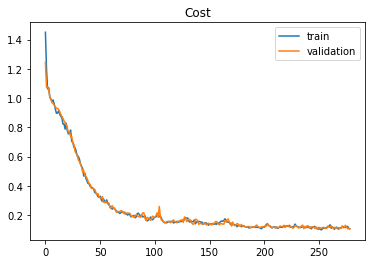

In [6]:
plt.title("Cost")
plt.plot(train_losses, label="train")
plt.plot(valid_losses, label="validation")
plt.legend()

## Load/Save model

In [ ]:
#torch.save(model.state_dict(), "../saved_weights/wind64_model")
#model.load_state_dict(torch.load("../saved_weights/wind6_model"))

# Testing

## Average and std correlation

test loss: 0.06947256624698639
correlation avg and std: 0.97009478021978 0.014938705420944583

spearman: 0.9747252747252746
spearman: 0.9775183150183149
spearman: 0.9198717948717947
spearman: 0.9870421245421244


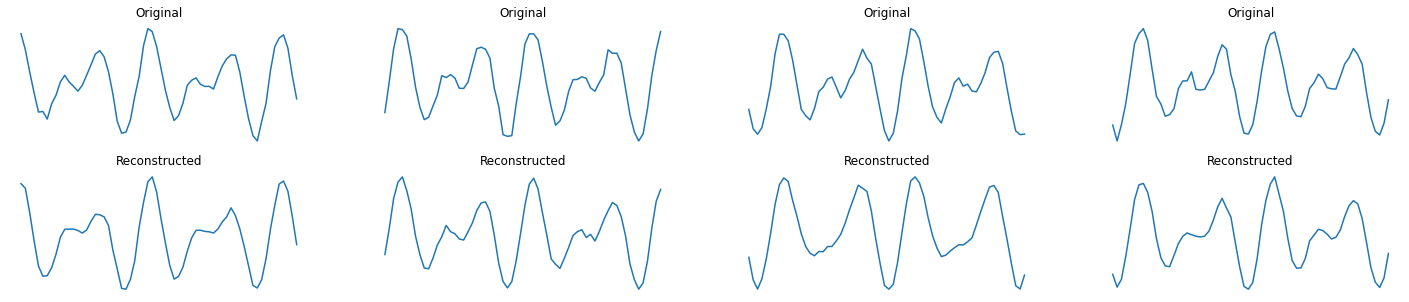

In [8]:
pred1 = model(X_test)

print(f"test loss: {model.loss(X_test)/(np.ceil(X_test.shape[0]/batch_size))}")

pred1 = pred1.detach().numpy()

# mean cors
cors = [scipy.stats.spearmanr(pred1[i,0], X_test[i,0]).correlation for i in range(n_test)]
print("correlation avg and std:", np.mean(cors), np.std(cors))
print()

# plot
n_plots = 4
start = n_plots*0

fig, axs = plt.subplots(nrows=2, ncols=n_plots, figsize=(25,5))
for i in range(n_plots):
    
    axs[0,i].axis("off")
    axs[0,i].set_title("Original")
    axs[0,i].plot(X_test[start+i,0])

    axs[1,i].axis("off")
    axs[1,i].set_title("Reconstructed")
    axs[1,i].plot(pred1[start+i,0])
    print("spearman:", scipy.stats.spearmanr(pred1[start+i,0], X_test[start+i,0]).correlation)

# Latent space

In [ ]:
#if bottleneck_nn == 2:
#    latent_space(model, n=10)

# Choose bootleneck

In [ ]:
#vals = choose_bottleneck(X_test, X_train, X_valid, length, M, Lf)
#plt.plot([np.mean(x) for x in vals], "-o", [1]*len(vals))

# Checking important filters

<AxesSubplot:>

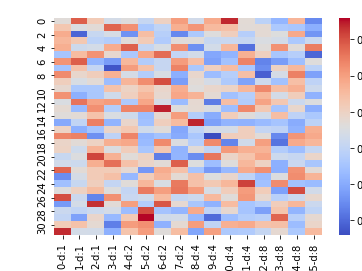

In [9]:
num_filter = 4*M
w_per_filter = length-Lf+1 # weights per filter
w = np.array([[torch.mean(torch.abs(model.full1.weight[j,i*w_per_filter:(i+1)*w_per_filter])).item() for i in range(num_filter)] for j in range(bottleneck_nn)])

x_axis_labels = [f"{i}-d:{2**(i//M)}" for i in range(w.shape[1])] # number of filter - d:dilatation
sns.heatmap(w, cmap="coolwarm", xticklabels=x_axis_labels) # y-axis => neuron of the bottleneck, x-axis => each position is one filter ordered by dilatation

# Clustering using bootlenecks

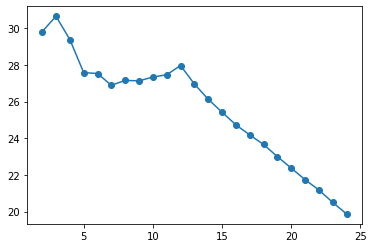

In [10]:
bns = model.forward(X_test, get_bottleneck=True).detach().numpy()
chs = []
for i in range(2,25):
    clustering = AgglomerativeClustering(n_clusters=i)
    clustering.fit(bns) 
    clus = clustering.labels_
    ch = calinski_harabasz_score(bns,clus)
    chs.append(ch)
plt.plot(range(2,len(chs)+2), chs, "o-")

In [11]:
clustering = AgglomerativeClustering(n_clusters=8)
clustering.fit(bns)
clus = clustering.labels_

In [12]:
if bns.shape[1] <= 10: # more than 10 plots is slow
    sns.pairplot(pd.DataFrame(bns))

<AxesSubplot:>

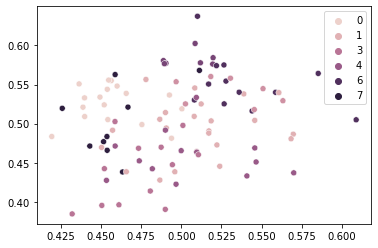

In [13]:
d1 = 0
d2 = 2
sns.scatterplot(bns[:,d1], bns[:,d2], clus)